In [10]:
import pandas as pd
import scipy as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [11]:
%matplotlib inline

In [12]:
def get_file_names(dataset_dir):
    result = {}
    for d, dirs, files in os.walk(dataset_dir):
        for name in files:
            result[name] = dataset_dir + '/' + name
    
    return result

def merge_csvs_into_df(csvs_path):
    metrics_files = get_file_names(csvs_path)
    output_df = pd.DataFrame()

    for metric in metrics_files.iterkeys():
        path = metrics_files[metric]
        metric_name = metric[:-4]
        metric_df = pd.read_csv(path)
        output_df['time'] = metric_df['time']
        output_df[metric_name] = metric_df[metric_name]
        
    return output_df

def extract_dataset():
    train = merge_csvs_into_df('datasets/train')
    test = merge_csvs_into_df('datasets/test')
        
    return train, test

def prepare_dataset(train, tests, input_parameters, predict_params):
    # Add daytime field in order to explore seasonality in data
    train['daytime'] = train['time'].apply(lambda x: x[6:])
    test['daytime'] = test['time'].apply(lambda x: x[6:])
    # Remove abgw_ prefixes from all column names for convenience
    train.rename(columns=lambda c: c.replace('abgw_', ''), inplace=True)
    test.rename(columns=lambda c: c.replace('abgw_', ''), inplace=True)
    
    train.dropna(inplace=True)
    test.dropna(inplace=True)
    
    train_X = train[input_parameters]
    train_y = train[predict_params]
    
    test_X = test[input_parameters]
    test_y = test[predict_params]
    
    return train_X, train_y, test_X, test_y

In [28]:
input_parameters = [
    'time',
    'daytime',
    'abgw_accounts',
    #'abgw_conns_total',
    'abgw_conns',
    'abgw_read_reqs_total',
    'abgw_write_reqs_total',
    'abgw_stat_reqs_total',
]

predict_params = [
    'time',
    'daytime',
    "abgw_account_lookup_errs_total",
    "abgw_account_pull_errs_total",
    "abgw_cert_update_fail_total",
    "abgw_containers_validate_segments_fail_total",
    "abgw_containers_validate_trees_fail_total",
    "abgw_crl_download_fail_total",
    "abgw_detached_files",
    "abgw_fds",
    "abgw_file_lookup_errs_total",
    "abgw_file_migration_source_open_errs_total",
    "abgw_file_migration_source_read_errs_total",
    "abgw_files",
    "abgw_io_limiting_failures_total",
    "abgw_iop_latency_ms_count",
    "abgw_iop_latency_ms_sum",
    "abgw_nr_files_to_pull",
    "abgw_pull_backlog_bytes",
    "abgw_pull_progress_bytes_total",
    "abgw_push_backlog_bytes",
    "abgw_push_progress_bytes_total",
    "abgw_read_bufs",
    "abgw_read_bufs_bytes",
    "abgw_read_bytes_total",
    "abgw_req_errs_total",
    "abgw_req_latency_ms_count",
    "abgw_req_latency_ms_sum",
    "abgw_verify_certs_errors_total",
    "abgw_write_bufs",
    "abgw_write_bufs_bytes",
    "abgw_write_bytes_total",
]

bad_metrics = [
    'abgw_cert_update_fail_total',
    'abgw_containers_validate_segments_fail_total',
    'abgw_containers_validate_trees_fail_total',
    'abgw_crl_download_fail_total',
    'abgw_detached_files',
    'abgw_fds',
    'abgw_file_migration_source_open_errs_total',
    'abgw_file_migration_source_read_errs_total',
    'abgw_files',
    'abgw_io_limiting_failures_total',
    'abgw_nr_files_to_pull',
    'abgw_pull_backlog_bytes',
    'abgw_pull_progress_bytes_total',
    'abgw_push_backlog_bytes',
    'abgw_push_progress_bytes_total',
    'abgw_read_bufs',
    'abgw_read_bufs_bytes',
    'abgw_req_latency_ms_sum',
    'abgw_verify_certs_errors_total',
    'abgw_write_bufs',
    'abgw_write_bufs_bytes',
]

predict_params = list(set(predict_params) - set(bad_metrics))

input_parameters = map(lambda s: s.replace('abgw_', ''), input_parameters)
predict_params = map(lambda s: s.replace('abgw_', ''), predict_params)

train, test = extract_dataset()
train_X, train_Y, test_X, test_Y = prepare_dataset(train, test, input_parameters, predict_params)

print predict_params

['read_bytes_total', 'req_latency_ms_count', 'daytime', 'file_lookup_errs_total', 'iop_latency_ms_count', 'write_bytes_total', 'time', 'req_errs_total', 'account_pull_errs_total', 'account_lookup_errs_total', 'iop_latency_ms_sum']


In [23]:
def train_models(result_metrics, train_X, train_Y):
    output_models = dict()
    
    for metric in result_metrics:
        regression_model = linear_model.LinearRegression()
        regression_model.fit(train_X, train_Y[metric])
        
        output_models[metric] = regression_model
    
    return output_models

def predict_metrics(predict_metrics, predict_models, storage_input, storage_output):
    total_result = dict()
    
    for metric_name in predict_metrics:
        total_result[metric_name] = pd.DataFrame()
        result = total_result[metric_name]
        
        predict_metric_name = "%s_predict" % (metric_name)
        
        # Save real result and prediction into separate columns
        result[metric_name] = storage_output[metric_name]
        result[predict_metric_name] = predict_models[metric_name].predict(storage_input)
        
        # Compute upper and lower borders of predict metric values
        metric_std_dev = result[predict_metric_name].std() * 0.2
        result['upper_border'] = result[predict_metric_name] + metric_std_dev
        result['lower_border'] = result[predict_metric_name] - metric_std_dev
        
    return total_result

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_errors(predicted_metrics, predict_result):
    print("Errors for linear regression models:")
    print("------------------------------------")
    
    linear_metrics, non_linear_metrics = [], []
    
    for predict_metric in predicted_metrics:
        result = predict_result[predict_metric]
        predict_metric_key = "%s_predict" % (predict_metric)
    
        print("%s:" %(predict_metric))
        mae = mean_absolute_error(result[predict_metric], result[predict_metric_key])
        print("\tMAE: \t  %s" % (mae))
        
        print("\tMAPE:\t  %.2f"
              % (mean_absolute_percentage_error(result[predict_metric],
                                                result[predict_metric_key])))

        # Explained variance score: 1 is perfect prediction
        metric_r2_score = r2_score(result[predict_metric], result[predict_metric_key])
        
        if metric_r2_score >= 0.9 and mae > 0:
            linear_metrics.append(predict_metric)
        else:
            non_linear_metrics.append(predict_metric)
            
        print('\tR2 Score: %.2f' % metric_r2_score)
        print("------------------------------------")
        
    return linear_metrics, non_linear_metrics

def dump_labels(labels, title):
    print(title)
    for label in labels:
        print('\t%s' % (label))

def draw_prediction_result(metric_name, predict_result):
    x = np.arange(predict_result.shape[0])
    metric_predict_name = "%s_predict" % (metric_name)
    
    plt.figure(figsize=(8,8))
    plt.plot(x, predict_result[metric_name], 'bo', label='reality',
             markersize=1)
    plt.plot(x, predict_result[metric_predict_name], 'go', label='prediction',
             markersize=1)
    plt.plot(x, predict_result['upper_border'], 'o', label='upper_border',
             markersize=1, color='orange')
    plt.plot(x, predict_result['lower_border'], 'o', label='lower_border',
             markersize=1, color='orange')
    
    plt.title('Reality vs Prediction')
    plt.xlabel('index')
    plt.ylabel(metric_name)
    plt.legend()
    
    plt.show()

In [31]:
# Exclude 'time' and 'daytime' fields from predictors and result
predictors = [x for x in input_parameters if x != 'time' and x != 'daytime']
predicted_metrics = [x for x in predict_params if x != 'time' and x != 'daytime']

print(predictors)
print(predicted_metrics)

output_models = train_models(predicted_metrics, train[predictors], train[predicted_metrics])

['accounts', 'conns', 'read_reqs_total', 'write_reqs_total', 'stat_reqs_total']
['read_bytes_total', 'req_latency_ms_count', 'file_lookup_errs_total', 'iop_latency_ms_count', 'write_bytes_total', 'req_errs_total', 'account_pull_errs_total', 'account_lookup_errs_total', 'iop_latency_ms_sum']


In [32]:
predict_result = predict_metrics(predicted_metrics, output_models,
                                 test[predictors], test[predicted_metrics])

linear_metrics, non_linear_metrics = evaluate_errors(predicted_metrics, predict_result)

Errors for linear regression models:
------------------------------------
read_bytes_total:
	MAE: 	  5.40670431529e+12
	MAPE:	  3.60
	R2 Score: 0.94
------------------------------------
req_latency_ms_count:
	MAE: 	  11443167.0996
	MAPE:	  0.83
	R2 Score: 0.99
------------------------------------
file_lookup_errs_total:
	MAE: 	  3513594.11189
	MAPE:	  0.34
	R2 Score: 1.00
------------------------------------
iop_latency_ms_count:
	MAE: 	  12855935.08
	MAPE:	  0.40
	R2 Score: 1.00
------------------------------------
write_bytes_total:
	MAE: 	  178790461155.0
	MAPE:	  0.08
	R2 Score: 1.00
------------------------------------
req_errs_total:
	MAE: 	  11442035.9937
	MAPE:	  0.82
	R2 Score: 0.99
------------------------------------
account_pull_errs_total:
	MAE: 	  5859825.30921
	MAPE:	  0.45
	R2 Score: 1.00
------------------------------------
account_lookup_errs_total:
	MAE: 	  29263415.2884
	MAPE:	  1.32
	R2 Score: 0.95
------------------------------------
iop_latency_ms_sum:
	MAE: 	  3

In [33]:
dump_labels(linear_metrics, "Linear metrics: ")
dump_labels(non_linear_metrics, "Non linear metrics: ")

Linear metrics: 
	read_bytes_total
	req_latency_ms_count
	file_lookup_errs_total
	iop_latency_ms_count
	write_bytes_total
	req_errs_total
	account_pull_errs_total
	account_lookup_errs_total
	iop_latency_ms_sum
Non linear metrics: 


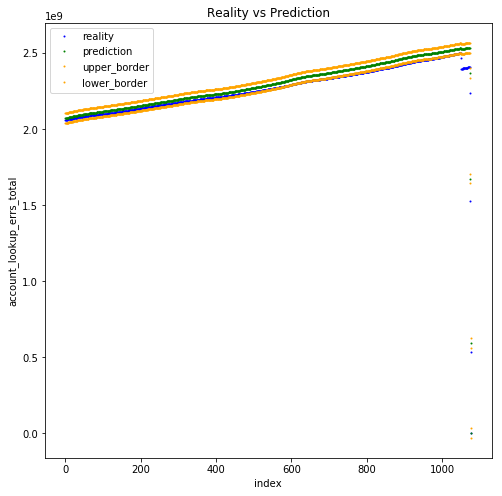

In [35]:
draw_prediction_result('account_lookup_errs_total', predict_result['account_lookup_errs_total'])

In [43]:
predict_len = predict_result['account_lookup_errs_total']['account_lookup_errs_total'].shape[0]
value_len = test['account_lookup_errs_total'].shape[0]
assert predict_len == value_len
metric_predict = predict_result['account_lookup_errs_total']['account_lookup_errs_total']
real_value = test['account_lookup_errs_total']

for i in xrange(predict_len):
    if metric_predict[i] != real_value[i]:
        print 'not true ' + i